# Machine Learning Exercise 12

# Dimensionality Reduction - MNIST 



##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


## Load data

Load training data from Keras library




In [ ]:
def load_data():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = keras.datasets.mnist.load_data()
    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    ntest = Xtest.shape[0]
    num_classes = max(Ytrain) + 1
    print("Training input %s" %str(Xtrain.shape))
    print("Training output %s" %str(Ytrain.shape))
    print("Test input %s" %str(Xtest.shape))
    print("Test output %s" %str(Ytest.shape))
    print("Input shape: %s" %str(input_shape))
    print("Number of classes: %d" %num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    # reshape input in 4D array
    Xtrain = Xtrain.reshape(ninput,imgsize[0],imgsize[1],1)
    Xtest = Xtest.reshape(ntest,imgsize[0],imgsize[1],1)
    
    # Transform output to one-out-of-n encoding
    Ytrain = keras.utils.to_categorical(Ytrain, num_classes)
    Ytest = keras.utils.to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]
  

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_data()

11493376/11490434 [==============================] - 1s 0us/step
Training input (60000, 28, 28)
Training output (60000,)
Test input (10000, 28, 28)
Test output (10000,)
Input shape: (28, 28, 1)
Number of classes: 10


## Show random image



8


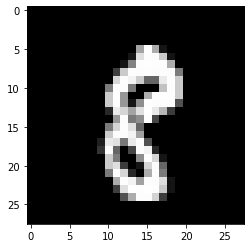

In [ ]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))

label = Ytrain[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(pixels, cmap='gray')
plt.show()


##PCA 

In [ ]:
# flatten the data
Xtrain_flatten = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1] * Xtrain.shape[2] * Xtrain.shape[3]))
Xtest_flatten = Xtest.reshape((Xtest.shape[0], Xtest.shape[1] * Xtest.shape[2] * Xtest.shape[3]))

print("The flatten shape of training data is (%s, %s)" % (Xtrain_flatten.shape[0], Xtrain_flatten.shape[1]))
print("The flatten shape of testing data is (%s, %s)" % (Xtest_flatten.shape[0], Xtest_flatten.shape[1]))

The flatten shape of training data is (60000, 784)
The flatten shape of testing data is (10000, 784)


In [ ]:
from sklearn.decomposition import PCA

# select the number of components for the PCA projection
n_components = 200

# execute PCA
pca = PCA(n_components = n_components)
Xtrain_pca = pca.fit_transform(Xtrain_flatten)
print("The shape of pca training data is (%s, %s)" % (Xtrain_pca.shape[0], Xtrain_pca.shape[1]))

The shape of pca training data is (60000, 200)


Check the forward and backward transformation 

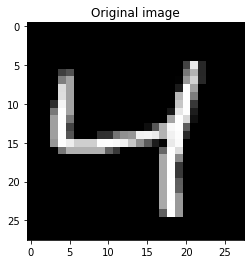

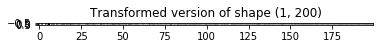

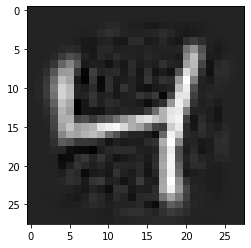

In [ ]:
# show the transformation forward and backwards
idx = 2

# original image
img_plot = np.array(Xtrain[idx], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Original image")

# transformed low dimensional representation
img_plot = np.array(Xtrain_pca[idx,:], dtype="float")
img_plot = img_plot.reshape((1,n_components))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Transformed version of shape {}".format(img_plot.shape))

# reconstructed image
img_plot = pca.inverse_transform(Xtrain_pca[idx,:])
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')


Plot the 2D or 3D components

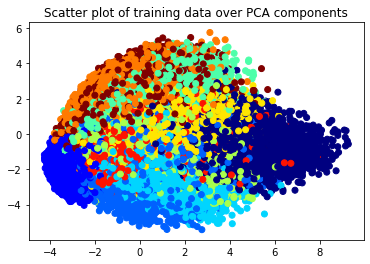

In [ ]:
# select the number of components for the PCA projection
n_components = 2

# execute PCA
pca = PCA(n_components = n_components)
Xtrain_pca = pca.fit_transform(Xtrain_flatten)

Ytrain_plot = np.argmax(Ytrain,axis=1)
Ytest_plot = np.argmax(Ytest,axis=1)

if n_components == 2:
  plt.figure()
  plt.title("Scatter plot of training data over PCA components")
  plt.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], c=Ytrain_plot, cmap='jet')

elif n_components == 3:
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = Axes3D(fig)
  plt.title("Scatter plot of PCA components")
  ax.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], Xtrain_pca[:,2], c=Ytrain_plot, cmap='jet')
  plt.show()

else:
  print("For a scatter plot use 2 or 3 principal components")

##Deep Autoencoder


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def DeepAutoencoder(input_shape, out_shape):
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu', name="dense1"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu', name="dense2"))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='relu', name="dense3"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu', name="dense4"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu', name="dense5"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu', name="dense6"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(out_shape, activation='relu', name="denseout"))

    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)
    
    return model
 
# create the model
input_shape = Xtrain_flatten.shape[1:]
out_shape = Xtrain_flatten.shape[1]
deep_ae = DeepAutoencoder(input_shape, out_shape)
deep_ae.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_82 (Batc (None, 784)               3136      
_________________________________________________________________
dropout_81 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense1 (Dense)               (None, 300)               235500    
_________________________________________________________________
batch_normalization_83 (Batc (None, 300)               1200      
_________________________________________________________________
dropout_82 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense2 (Dense)               (None, 150)               45150     
_________________________________________________________________
batch_normalization_84 (Batc (None, 150)             

In [ ]:
epochs = 30
history = deep_ae.fit(Xtrain_flatten, Xtrain_flatten, batch_size=256, epochs=epochs, validation_data=(Xtest_flatten, Xtest_flatten), 
                      verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 160us/step - loss: 0.0890 - val_loss: 0.0645
Epoch 2/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.0649 - val_loss: 0.0613
Epoch 3/30
60000/60000 [==============================] - 5s 76us/step - loss: 0.0615 - val_loss: 0.0585
Epoch 4/30
60000/60000 [==============================] - 5s 75us/step - loss: 0.0593 - val_loss: 0.0570
Epoch 5/30
60000/60000 [==============================] - 4s 75us/step - loss: 0.0581 - val_loss: 0.0541
Epoch 6/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0567 - val_loss: 0.0532
Epoch 7/30
60000/60000 [==============================] - 5s 76us/step - loss: 0.0562 - val_loss: 0.0521
Epoch 8/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0557 - val_loss: 0.0521
Epoch 9/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.0552 - val_loss: 0.0510
Epo

Check the Deep Autoencoder reconstruction over test images

Text(0.5, 1.0, 'Deep Autoencoder reconstruction')

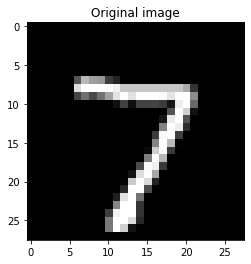

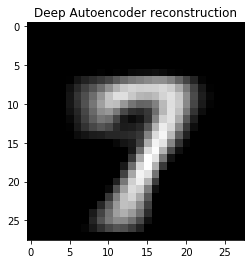

In [ ]:
# show the encoder-decoder reconstruction
idx = 0

# original image
img_plot = np.array(Xtest_flatten[idx, :], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Original image")

Xtest_flatten_pred = deep_ae.predict(Xtest_flatten)

img_plot = np.array(Xtest_flatten_pred[idx,:], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Deep Autoencoder reconstruction")

In [ ]:
from keras.models import Model

def layer_extractor(model, layer_name):
    
    # define the input tensor
    original_input = model.get_layer(index=0).input

    # define the output tensor
    output_layer = model.get_layer(name=layer_name).output
    
    # compile the model
    extractor = Model(input=original_input, output=output_layer)
    optimizer = 'adam' #alternative 'SGD'
    extractor.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)

    return extractor

# dense3 is the bottleneck layer (you can extract the output from any layer)
layer_name = "dense3"
encoder = layer_extractor(deep_ae, layer_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("de...)`
  if sys.path[0] == '':


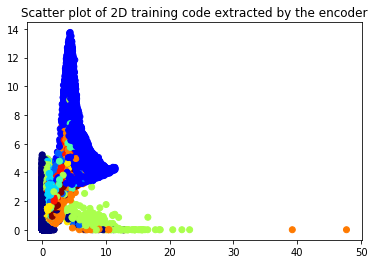

In [ ]:
# predict the training data to check if the encoder is better than PCA
encoder_predictions = encoder.predict(Xtrain_flatten)

plt.figure()
plt.title("Scatter plot of 2D training code extracted by the encoder")
plt.scatter(encoder_predictions[:,0], encoder_predictions[:,1], c=Ytrain_plot, cmap='jet')

## Evaluate low dimensional (2D) transformation with classification task

Overall accuracy, precision, recall and F-score 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# train the model using the encoder predictions (samples x features) training sets
knn_model = KNeighborsClassifier(n_neighbors=200)
knn_model.fit(encoder_predictions, Ytrain_plot)

test_encoder_features =  encoder.predict(Xtest_flatten)
knn_pred_encoder = knn_model.predict(test_encoder_features)

accuracy_knn_encoder = accuracy_score(Ytest_plot, knn_pred_encoder)
print("Accuracy obtained with KNN + 2D features extracted from Deep Autoencoder: %s" %accuracy_knn_encoder)

# train the knn model with pca 2D features
pca = PCA(n_components = 2)
train_pca_features = pca.fit_transform(Xtrain_flatten)

knn_model = KNeighborsClassifier(n_neighbors=200)
knn_model.fit(train_pca_features, Ytrain_plot)

test_pca_features = pca.transform(Xtest_flatten)
knn_pred_pca = knn_model.predict(test_pca_features)

accuracy_knn_pca = accuracy_score(Ytest_plot, knn_pred_pca)
print("Accuracy obtained with KNN + 2D features extracted from PCA: %s" %accuracy_knn_pca)


Accuracy obtained with KNN + 2D features extracted from Deep Autoencoder: 0.7397
Accuracy obtained with KNN + 2D features extracted from PCA: 0.4788
